# Loading the dataset
German credit dataset has been chosen for this analysis. This dataset has been frequently used in fairness-aware research.

The dataset is loaded from sklearn library bank of datasets.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
# Load the German Credit Dataset
german_credit = fetch_openml('credit-g', version=1, as_frame=True)
df = german_credit.frame
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


# Preprocessing the data
We put a threshold for the 'Age' attribute and choose it as the sensitive attribute in our analysis. Above 25 is previleged and below that is unprevileged

In [3]:
# Create a sensitive attribute (binary): 1 if Age >= 25, else 0
df['age'] = (df['age'] >= 25).astype(int)

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['category']).columns:
    df[col] = le.fit_transform(df[col])

# Standardize numerical features
scaler = StandardScaler()
df[['duration', 'credit_amount', 'installment_commitment', 'residence_since']] = scaler.fit_transform(df[['duration', 'credit_amount', 'installment_commitment', 'residence_since']])

# Features and Target
X = df.drop(columns=['class'])
y = df['class']
sensitive_idx = X.columns.get_loc('age')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,-1.236478,1,6,-0.745131,4,3,0.918477,3,2,...,3,1,1,1,2,1,1,1,1,1
1,0,2.248194,3,6,0.949817,2,0,-0.870183,0,2,...,3,0,1,1,1,1,1,0,1,0
2,3,-0.738668,1,2,-0.416562,2,1,-0.870183,3,2,...,3,1,1,1,1,3,2,0,1,1
3,1,1.750384,3,3,1.634247,2,1,-0.870183,3,1,...,1,1,1,0,1,1,2,0,1,1
4,1,0.256953,2,4,0.566664,2,0,0.024147,3,2,...,2,1,1,0,2,1,2,0,1,0


In [4]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['age'], df['class'])

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")

# Interpret result
if p < 0.05:
    print("There is a statistically significant relationship between age and credit risk.")
else:
    print("There is no statistically significant relationship between age and credit risk.")


Chi-Square Statistic: 9.3752
p-value: 0.0022
There is a statistically significant relationship between age and credit risk.


The Chi-Square test reveals a statistically **significant relationship between age and credit risk** (p = 0.0022), indicating that the distribution of credit risk (good or bad) is not independent of age group (≤25 vs. >25). Given that the p-value is well below the commonly used significance level of 0.05, we can reject the null hypothesis that age and credit risk are independent of each other.

<ipython-input-5-a726d59445a1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='class', palette=['#FF7043', '#4CAF50'], ax=axes[0])
<ipython-input-5-a726d59445a1>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age', palette=['#FFC107', '#03A9F4'], ax=axes[1])


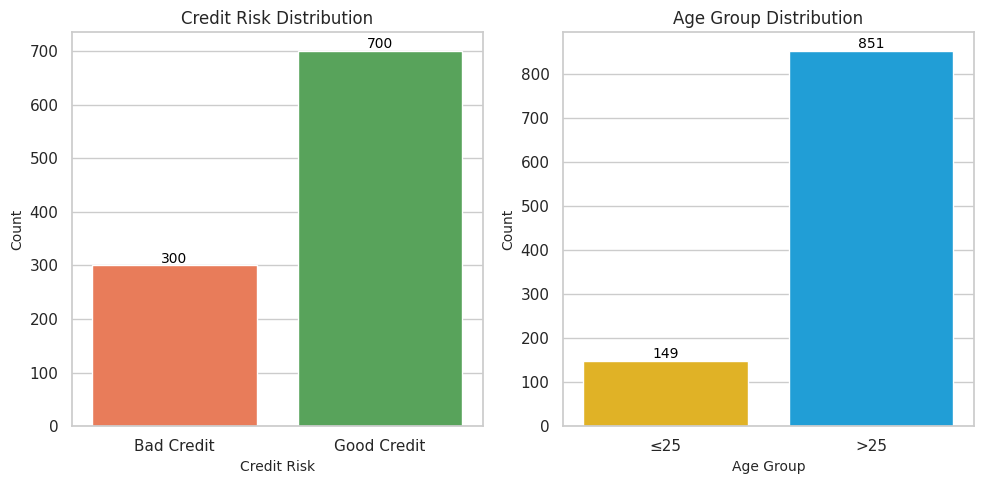

In [5]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Distribution of 'class' (credit risk)
sns.countplot(data=df, x='class', palette=['#FF7043', '#4CAF50'], ax=axes[0])

# Add value labels on top of each bar
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Set titles and labels for the first plot
axes[0].set_title('Credit Risk Distribution', fontsize=12)
axes[0].set_xlabel('Credit Risk', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Bad Credit', 'Good Credit'])

# Plot 2: Distribution of 'age' group (≤25 vs. >25)
sns.countplot(data=df, x='age', palette=['#FFC107', '#03A9F4'], ax=axes[1])

# Add value labels on top of each bar
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Set titles and labels for the second plot
axes[1].set_title('Age Group Distribution', fontsize=12)
axes[1].set_xlabel('Age Group', fontsize=10)
axes[1].set_ylabel('Count', fontsize=10)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['≤25', '>25'])


plt.tight_layout()
plt.show()

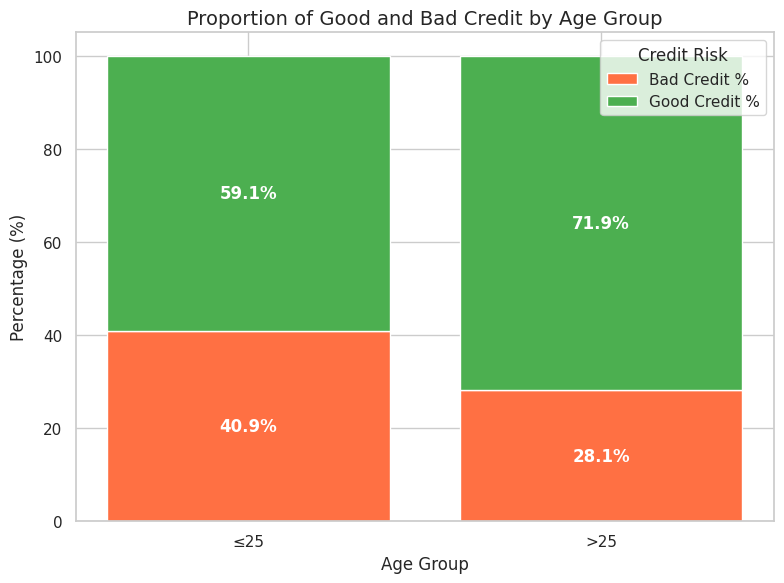

In [6]:
# Calculating actual values of good and bad credit risk by age group
age_groups = df.groupby('age')['class'].value_counts().unstack().fillna(0)

age_groups.columns = ['Bad Credit', 'Good Credit']
age_groups.index = ['≤25', '>25']

# Calculate total per group and percentages
age_groups['Total'] = age_groups['Bad Credit'] + age_groups['Good Credit']
age_groups['Bad Credit %'] = (age_groups['Bad Credit'] / age_groups['Total']) * 100
age_groups['Good Credit %'] = (age_groups['Good Credit'] / age_groups['Total']) * 100

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")


bar1 = plt.bar(age_groups.index, age_groups['Bad Credit %'], color='#FF7043', label='Bad Credit %')

bar2 = plt.bar(age_groups.index, age_groups['Good Credit %'], bottom=age_groups['Bad Credit %'], color='#4CAF50', label='Good Credit %')

# Add percentage annotations
for idx, (bad_credit, good_credit) in enumerate(zip(age_groups['Bad Credit %'], age_groups['Good Credit %'])):

    plt.text(idx, bad_credit / 2, f'{bad_credit:.1f}%', ha='center', va='center', color='white', fontweight='bold')


    plt.text(idx, bad_credit + good_credit / 2, f'{good_credit:.1f}%', ha='center', va='center', color='white', fontweight='bold')


plt.title('Proportion of Good and Bad Credit by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([0, 1], labels=['≤25', '>25'], rotation=0)
plt.legend(title='Credit Risk', loc='upper right')

plt.tight_layout()
plt.show()


The plot clearly demonstrates that **age** is a sensitive attribute in this dataset, highlighting a disparity between the younger and older populations in terms of **credit risk**.

Specifically, around **40.9%** of individuals **aged 25 or younger** are classified as having **bad credit**, whereas only **28.1%** of individuals **older than 25** are similarly classified.

This difference suggests that younger people are disproportionately considered as higher credit risks compared to their older counterparts. Such results indicate potential **discrimination** within the dataset, as the younger age group appears to be more negatively impacted in terms of creditworthiness evaluation.


# Costum decision tree implementation

In [7]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion='ig', sensitive_attr_idx=None):#
        """
        Initialize the decision tree.

        :param max_depth: Maximum depth of the tree.
        :param criterion: 'ig' for Information Gain, 'fig' for Fair Information Gain.
        :param sensitive_attr_idx: Index of the sensitive attribute for fairness calculation (only used for 'fig').
        """

        self.max_depth = max_depth
        self.sensitive_attr_idx = sensitive_attr_idx#
        self.tree = None
        self.feature_selection_log = []  # Track chosen features
        self.depth_log = {}  # Track depth at each split
        self.gain_log = []  # Track gain for each split

        valid_criteria = ['ig', 'fig']

        if criterion not in valid_criteria:
            raise ValueError(f"Invalid criterion '{criterion}'. Valid options are {valid_criteria}.")

        if criterion == 'fig' and sensitive_attr_idx is None:
            raise ValueError("For 'fig' criterion, you must provide sensitive_attr_idx.")

        self.criterion = criterion

    def _entropy(self, y):
        # Calculate the entropy of the class labels
        class_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy

    def _information_gain(self, y, y_left, y_right):
        # Calculate the information gain
        parent_entropy = self._entropy(y)
        left_weight = len(y_left) / len(y)
        right_weight = len(y_right) / len(y)
        gain = parent_entropy - (left_weight * self._entropy(y_left) + right_weight * self._entropy(y_right))
        return gain

    def _discrimination(self, X, y):

        # Calculate the statistical disparity based on the sensitive attribute.

        ## sensitive_attr_idx ==> The sensitive attribute index in X
        ## Deprived = 0
        ## Favored = 1
        ## y == 0 or y==1 ===> The class labels (granted or rejected)


        DR = np.sum((X[:, self.sensitive_attr_idx] == 0) & (y == 0))  # Deprived-Rejected
        DG = np.sum((X[:, self.sensitive_attr_idx] == 0) & (y == 1))  # Deprived-Granted
        FR = np.sum((X[:, self.sensitive_attr_idx] == 1) & (y == 0))  # Favored-Rejected
        FG = np.sum((X[:, self.sensitive_attr_idx] == 1) & (y == 1))  # Favored-Granted

        Disc_D = (FG / (FG + FR + 1e-8)) - (DG / (DG + DR + 1e-8))
        return Disc_D

    def _fair_gain(self, X, X_left, X_right, y, y_left, y_right):
        # Calculate the fair gain based on statistical disparity.
        parent_disc = abs(self._discrimination(X, y))
        left_weight = len(y_left) / len(y)
        right_weight = len(y_right) / len(y)
        left_disc = abs(self._discrimination(X_left, y_left))
        right_disc = abs(self._discrimination(X_right, y_right))

        fair_gain = parent_disc - ((left_weight) * (left_disc) + (right_weight) * (right_disc))
        return fair_gain

    def _information_fair_gain(self, X, X_left, X_right, y, y_left, y_right):
        # Combine information gain and fair gain.
        fair_gain = self._fair_gain(X, X_left, X_right, y, y_left, y_right)
        ig = self._information_gain(y, y_left, y_right)

        if fair_gain == 0:
            return ig
        else:
            return ig * fair_gain

    def _best_split(self, X, y, depth):
        # Find the best split based on the chosen criterion (information gain or fair information gain).
        best_gain = -1
        best_split = None
        best_left_indices = None
        best_right_indices = None

        for feature_idx in range(X.shape[1]):
            feature_values = X[:, feature_idx]
            for threshold in np.unique(feature_values):
                left_indices = np.where(feature_values <= threshold)[0]
                right_indices = np.where(feature_values > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                X_left = X[left_indices]
                X_right = X[right_indices]
                y_left = y[left_indices]
                y_right = y[right_indices]


                # Depending on the criterion, calculate the corresponding gain
                if self.criterion == 'fig' and self.sensitive_attr_idx is not None:
                    gain = self._information_fair_gain(X, X_left, X_right, y, y_left, y_right)
                else:
                    gain = self._information_gain(y, y_left, y_right)


                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_idx, threshold)
                    best_left_indices = left_indices
                    best_right_indices = right_indices

        # Record chosen feature and gain for analysis
        if best_split:
            self.feature_selection_log.append(best_split[0])
            self.depth_log[depth] = self.depth_log.get(depth, 0) + 1
            self.gain_log.append(best_gain)

        return best_split, best_left_indices, best_right_indices

    def _build_tree(self, X, y, depth):
        # Recursively build the decision tree
        if len(np.unique(y)) == 1 or len(y) == 0:
            return np.unique(y)[0] if len(y) > 0 else None

        if self.max_depth is not None and depth >= self.max_depth:
            return np.bincount(y).argmax()

        # Log depth level for each split
        self.depth_log[depth] = self.depth_log.get(depth, 0) + 1

        best_split, left_indices, right_indices = self._best_split(X, y, depth)

        if best_split is None:
            return np.bincount(y).argmax()

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'split_feature': best_split[0], 'threshold': best_split[1],
                'left': left_subtree, 'right': right_subtree}

    def fit(self, X, y):
        # Train the decision tree model
        self.tree = self._build_tree(np.array(X), np.array(y), 0)

    def _predict_single(self, x, tree):
        # Predict the class label for a single data point
        if not isinstance(tree, dict):
            return tree

        feature_idx = tree['split_feature']
        threshold = tree['threshold']

        if x[feature_idx] <= threshold:
            return self._predict_single(x, tree['left'])
        else:
            return self._predict_single(x, tree['right'])

    def predict(self, X):
        # Predict the class labels for a dataset
        return np.array([self._predict_single(x, self.tree) for x in X])

# Training the IG & FIG decision trees

In [8]:
# Get the values of the dataframes
X = X.values
y = y.values

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create instances of the DecisionTree and fit it on the training set
ig_tree = DecisionTree(max_depth=3, criterion='ig')
ig_tree.fit(X_train, y_train)

fig_tree = DecisionTree(max_depth=3, criterion='fig', sensitive_attr_idx=sensitive_idx)
fig_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ig = ig_tree.predict(X_test)
y_pred_fig = fig_tree.predict(X_test)

# Performance and Fairness evaluation

In [10]:
def evaluate_performance(model, X_test, y_test):
    # Get predictions from the model
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

print('IG:')
evaluate_performance(ig_tree, X_test, y_test)
print('\nFIG:')
evaluate_performance(fig_tree, X_test, y_test)

IG:
Accuracy: 0.7550
Precision: 0.7987
Recall: 0.8723
F1 Score: 0.8339
Confusion Matrix:
[[ 28  31]
 [ 18 123]]

FIG:
Accuracy: 0.7400
Precision: 0.8027
Recall: 0.8369
F1 Score: 0.8194
Confusion Matrix:
[[ 30  29]
 [ 23 118]]


In [11]:
# Evaluate fairness using statistical parity
# Proportion of Class 1 predictions for Sensitive Attribute = 1 and = 0
sensitive_test = X_test[:, sensitive_idx]

ig_stat_parity_sensitive_1 = np.mean(y_pred_ig[sensitive_test == 1])
ig_stat_parity_sensitive_0 = np.mean(y_pred_ig[sensitive_test == 0])

ig_stat_parity_diff = abs(ig_stat_parity_sensitive_1 - ig_stat_parity_sensitive_0)

fig_stat_parity_sensitive_1 = np.mean(y_pred_fig[sensitive_test == 1])
fig_stat_parity_sensitive_0 = np.mean(y_pred_fig[sensitive_test == 0])

fig_stat_parity_diff = abs(fig_stat_parity_sensitive_1 - fig_stat_parity_sensitive_0)

print('IG:')
print(f"Prediction rate for class 'good' when Sensitive Attribute (age) = 1: {ig_stat_parity_sensitive_1:.2f}")
print(f"Prediction rate for class 'good' when Sensitive Attribute (age) = 0: {ig_stat_parity_sensitive_0:.2f}")
print(f"Statistical Parity Difference: {ig_stat_parity_diff:.2f}")

print('\nFIG:')
print(f"Prediction rate for Class 'good' when Sensitive Attribute = 1: {fig_stat_parity_sensitive_1:.2f}")
print(f"Prediction rate for Class 'good' when Sensitive Attribute = 0: {fig_stat_parity_sensitive_0:.2f}")
print(f"Statistical Parity Difference: {fig_stat_parity_diff:.2f}")

IG:
Prediction rate for class 'good' when Sensitive Attribute (age) = 1: 0.80
Prediction rate for class 'good' when Sensitive Attribute (age) = 0: 0.59
Statistical Parity Difference: 0.21

FIG:
Prediction rate for Class 'good' when Sensitive Attribute = 1: 0.75
Prediction rate for Class 'good' when Sensitive Attribute = 0: 0.66
Statistical Parity Difference: 0.09


In [12]:
def demographic_parity(y_pred, sensitive_attr):
    # Calculate the rate of positive outcomes for each sensitive group
    positive_outcome_rate_0 = np.mean(y_pred[sensitive_attr == 0])
    positive_outcome_rate_1 = np.mean(y_pred[sensitive_attr == 1])

    dp_ratio = positive_outcome_rate_0 / positive_outcome_rate_1
    return dp_ratio


print("IG Model - Demographic Parity:", demographic_parity(y_pred_ig, sensitive_test))
print("FIG Model - Demographic Parity:", demographic_parity(y_pred_fig, sensitive_test))


IG Model - Demographic Parity: 0.7388888888888888
FIG Model - Demographic Parity: 0.875


In [13]:
def discrimination(X, y, sensitive_attr_idx=12):

    DR = np.sum((X[:, sensitive_attr_idx] == 0) & (y == 0))  # Deprived-Rejected
    DG = np.sum((X[:, sensitive_attr_idx] == 0) & (y == 1))  # Deprived-Granted
    FR = np.sum((X[:, sensitive_attr_idx] == 1) & (y == 0))  # Favored-Rejected
    FG = np.sum((X[:, sensitive_attr_idx] == 1) & (y == 1))  # Favored-Granted

    Disc_D = (FG / (FG + FR + 1e-8)) - (DG / (DG + DR + 1e-8))

    return Disc_D

# Calculate discrimination for y_test, y_pred_ig, and y_pred_fig
actual_discrimination = discrimination(X_test, y_test)
ig_discrimination = discrimination(X_test, y_pred_ig)
fig_discrimination = discrimination(X_test, y_pred_fig)

discrimination_results = pd.DataFrame({
    "Model": ["Actual", "IG", "FIG"],
    "Discrimination Score": [actual_discrimination, ig_discrimination, fig_discrimination]
})
discrimination_results

,Model,Discrimination Score
0,Actual,0.020833
1,IG,0.209821
2,FIG,0.093750


In [14]:
feature_names = df.columns

# Get unique features selected in both IG and FIG
unique_features = np.unique(ig_tree.feature_selection_log + fig_tree.feature_selection_log)

# Map unique features to their names
feature_names_map = {i: feature_names[i] for i in unique_features}

# Calculate the frequency of selection for each feature in both models
feature_counts_ig = [ig_tree.feature_selection_log.count(f) for f in unique_features]
feature_counts_fig = [fig_tree.feature_selection_log.count(f) for f in unique_features]

feature_selection_df = pd.DataFrame({
    'Feature Name': [feature_names_map[i] for i in unique_features],
    'IG Selection Count': feature_counts_ig,
    'FIG Selection Count': feature_counts_fig
})

feature_selection_df

,Feature Name,IG Selection Count,FIG Selection Count
0,checking_status,1,1
1,duration,1,2
2,credit_history,1,1
3,purpose,1,0
4,credit_amount,1,0
5,savings_status,1,0
6,personal_status,0,1
7,property_magnitude,0,1
8,other_payment_plans,1,0
9,housing,0,1


In [15]:
def equalized_odds(y_true, y_pred, sensitive_attr):
    # Group-wise confusion matrix
    cm_group_0 = confusion_matrix(y_true[sensitive_attr == 0], y_pred[sensitive_attr == 0])
    cm_group_1 = confusion_matrix(y_true[sensitive_attr == 1], y_pred[sensitive_attr == 1])

    # Calculate TPR and FPR for each group
    tpr_0 = cm_group_0[1, 1] / (cm_group_0[1, 1] + cm_group_0[1, 0])  # TPR for group 0
    fpr_0 = cm_group_0[0, 1] / (cm_group_0[0, 1] + cm_group_0[0, 0])  # FPR for group 0

    tpr_1 = cm_group_1[1, 1] / (cm_group_1[1, 1] + cm_group_1[1, 0])  # TPR for group 1
    fpr_1 = cm_group_1[0, 1] / (cm_group_1[0, 1] + cm_group_1[0, 0])  # FPR for group 1

    return (tpr_0, fpr_0), (tpr_1, fpr_1)

tpr_fpr_ig_group_0, tpr_fpr_ig_group_1 = equalized_odds(y_test, y_pred_ig, sensitive_test)
tpr_fpr_fig_group_0, tpr_fpr_fig_group_1 = equalized_odds(y_test, y_pred_fig, sensitive_test)

print("IG Model - Equalized Odds (Group 0):", tpr_fpr_ig_group_0)
print("IG Model - Equalized Odds (Group 1):", tpr_fpr_ig_group_1)

print("FIG Model - Equalized Odds (Group 0):", tpr_fpr_fig_group_0)
print("FIG Model - Equalized Odds (Group 1):", tpr_fpr_fig_group_1)

IG Model - Equalized Odds (Group 0): (0.7727272727272727, 0.2)
IG Model - Equalized Odds (Group 1): (0.8907563025210085, 0.5918367346938775)
FIG Model - Equalized Odds (Group 0): (0.7272727272727273, 0.5)
FIG Model - Equalized Odds (Group 1): (0.8571428571428571, 0.4897959183673469)


In [16]:
def predictive_parity(y_true, y_pred, sensitive_attr):
    # Group 0 (Unprivileged Group)
    y_true_group_0 = y_true[sensitive_attr == 0]
    y_pred_group_0 = y_pred[sensitive_attr == 0]

    # Group 1 (Privileged Group)
    y_true_group_1 = y_true[sensitive_attr == 1]
    y_pred_group_1 = y_pred[sensitive_attr == 1]

    # Confusion matrices for both groups
    tn_0, fp_0, fn_0, tp_0 = confusion_matrix(y_true_group_0, y_pred_group_0).ravel()
    tn_1, fp_1, fn_1, tp_1 = confusion_matrix(y_true_group_1, y_pred_group_1).ravel()

    precision_group_0 = tp_0 / (tp_0 + fp_0) if (tp_0 + fp_0) > 0 else 0
    precision_group_1 = tp_1 / (tp_1 + fp_1) if (tp_1 + fp_1) > 0 else 0

    print(f"Precision for Group 0 (Unprivileged): {precision_group_0:.4f}")
    print(f"Precision for Group 1 (Privileged): {precision_group_1:.4f}")

    return precision_group_0, precision_group_1

predictive_parity(y_test, y_pred_ig, sensitive_test)
predictive_parity(y_test, y_pred_fig, sensitive_test)

Precision for Group 0 (Unprivileged): 0.8947
Precision for Group 1 (Privileged): 0.7852
Precision for Group 0 (Unprivileged): 0.7619
Precision for Group 1 (Privileged): 0.8095


(0.7619047619047619, 0.8095238095238095)

In [17]:
def mcnemars_test(y_true, y_pred_ig, y_pred_fig):
    # Initialize the contingency table counts
    b = 0  # IG correct, FIG incorrect
    c = 0  # FIG correct, IG incorrect

    for i in range(len(y_true)):
        if y_pred_ig[i] == y_true[i] and y_pred_fig[i] != y_true[i]:
            b += 1
        elif y_pred_ig[i] != y_true[i] and y_pred_fig[i] == y_true[i]:
            c += 1

    # Contingency table: [[a, b], [c, d]]
    table = [[0, b], [c, 0]]

    result = mcnemar(table, exact=False, correction=True)  # exact=False uses chi-square approximation
    print(f"McNemar's test statistic: {result.statistic}")
    print(f"P-value: {result.pvalue}")

    return result.statistic, result.pvalue

mcnemars_test(y_test, y_pred_ig, y_pred_fig)

McNemar's test statistic: 0.09302325581395349
P-value: 0.7603683300552028


(0.09302325581395349, 0.7603683300552028)

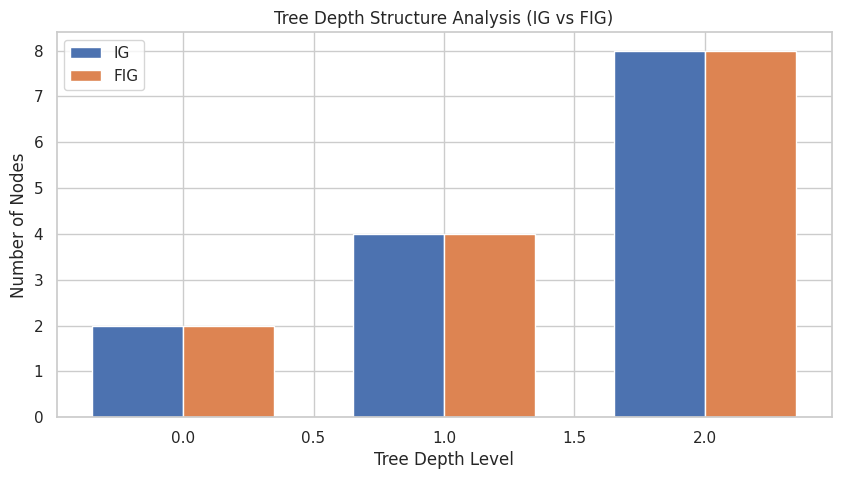

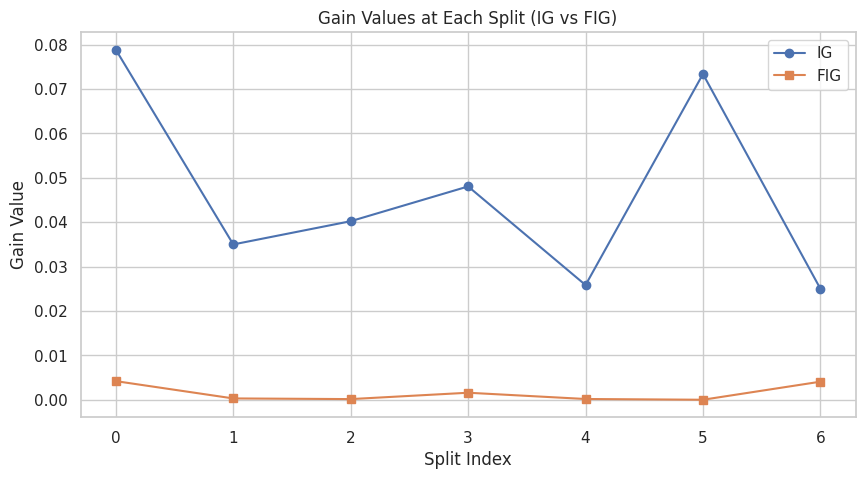

In [19]:
import matplotlib.pyplot as plt
import numpy as np

all_depths = sorted(set(ig_tree.depth_log.keys()).union(set(fig_tree.depth_log.keys())))
node_counts_ig = [ig_tree.depth_log.get(depth, 0) for depth in all_depths]
node_counts_fig = [fig_tree.depth_log.get(depth, 0) for depth in all_depths]

# Plot depth distribution for both IG and FIG models based on depth_log
plt.figure(figsize=(10, 5))
width = 0.35
plt.bar(np.array(all_depths) - width/2, node_counts_ig, width, label="IG", align="center")
plt.bar(np.array(all_depths) + width/2, node_counts_fig, width, label="FIG", align="center")
plt.xlabel("Tree Depth Level")
plt.ylabel("Number of Nodes")
plt.title("Tree Depth Structure Analysis (IG vs FIG)")
plt.legend()
plt.show()


# Plot gain values for IG and FIG models across splits
plt.figure(figsize=(10, 5))
plt.plot(range(len(ig_tree.gain_log)), ig_tree.gain_log, marker='o', label="IG")
plt.plot(range(len(fig_tree.gain_log)), fig_tree.gain_log, marker='s', label="FIG")
plt.xlabel("Split Index")
plt.ylabel("Gain Value")
plt.title("Gain Values at Each Split (IG vs FIG)")
plt.legend()
plt.show()
